<a href="https://colab.research.google.com/github/rrfsantos/Projeto-Redes-Neurais-OCT-Images/blob/main/OCT2017_Xception_classifier_kfold5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Métodos automatizados para detectar e classificar doenças humanas a partir de imagens médicas, utilizando aprendizado profundo 

Projeto de conclusão do curso BI-MASTER na PUC-RJ

Aluna: Renata Regina da Fonseca Santos

Orientadora: Professora Evelyn Conceição


## Objetivo

Utilização de modelos de inteligência artificial pré-treinados como alternativa para predição de diagnóstico em novos exames expostos aos modelos. Itens do trabalho:

*   Análise exploratória dos dados
*   Tratamento dos dados para uso na rede neural
*   Investigar as melhores opções de configuração para o caso proposto


## Descrição dos dados

O dataset é composto por imagens de Tomografia de Coerência Óptica da Retina (OCT), técnica de imagem usada para capturar seções transversais de alta resolução das retinas. É organizado em 3 diretórios (train, test, val). Cada um desses diretórios contém subdiretórios para cada categoria de imagem (NORMAL, CNV, DME,DRUSEN). São 84,495 imagens (JPEG) e 4 categorias:

*   CNV (choroidal neovascularization) -  Processo patológico que consiste da formação de novos vasos sanguíneos na COROIDE.

*   DME (diabetic macular edema) - Ao longo do tempo, níveis glicêmicos altos podem levar a complicações vasculares em vários tecidos e órgãos, como no coração, sistema nervoso, rins, membros inferiores (pernas e pés) e inclusive nos olhos.

*   DRUSEN - pequenos depósitos amarelos ou brancos na retina do olho ou na cabeça do nervo óptico. A presença de drusas é um dos sinais precoces mais comuns de degeneração macular relacionada à idade.

*   NORMAL



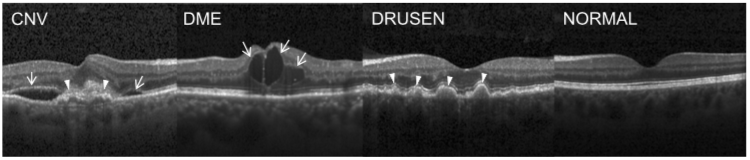

Labeled Optical Coherence Tomography (OCT) Images for Classification - Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, v2





### Instalação de pré-requisitos e Importação das Bibliotecas

Este trabalho baseou-se na API Keras para a construção da rede neural para inferência dos diagnósticos.

https://keras.io

In [ ]:
### Keras ###
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


### sklearn
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

### Demais Bibliotecas ###
import pandas as pd
import numpy as np
import shutil
import random
import os
import glob
import matplotlib.pyplot as plt
import warnings
import sys
from IPython.lib import deepreload 
import cv2

warnings.filterwarnings("ignore")
np.random.seed(0)
tf.random.set_seed(0)

## Análise Exploratória

### Visualização de 4 imagens de cada classe do dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

!unzip -o -q '/content/drive/MyDrive/TCC/oct_kfolds/kfold_5.zip' -d '/content'
!unzip -o -q  '/content/drive/MyDrive/TCC/oct_kfolds/test.zip' -d '/content/test'

Mounted at /content/drive/


In [ ]:
trainDataDir = 'train/'
validationDataDir = 'val/'
testDataDir = 'test/' # As imagens para inferência são as mesmas para todos os folds
saveResultDir = '/content/drive/MyDrive/TCC/oct_kfolds/'

classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

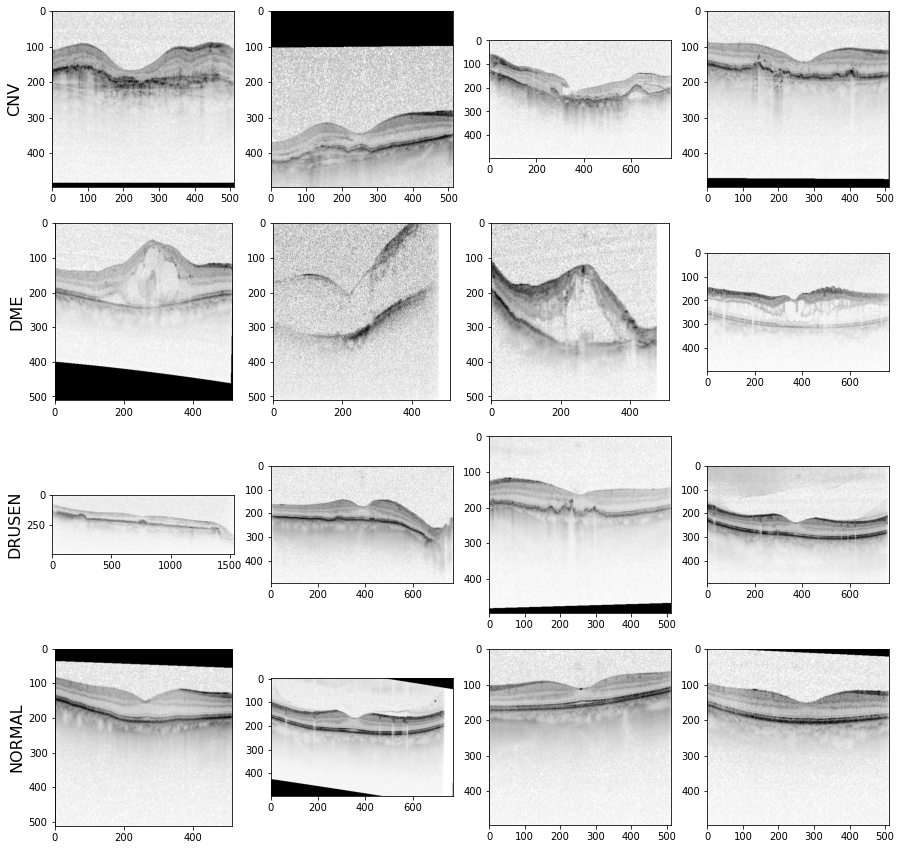

In [ ]:
cnv_examples = glob.glob(trainDataDir + 'CNV/*')
dme_examples = glob.glob(trainDataDir + 'DME/*')
drusen_examples = glob.glob(trainDataDir + 'DRUSEN/*')
normal_examples = glob.glob(trainDataDir + 'NORMAL/*')

examples = cnv_examples[:4] + dme_examples[:4] + drusen_examples[:4] + normal_examples[:4]

fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 4
for i in range(columns*rows):
    img = plt.imread(examples[i])
    ax = fig.add_subplot(rows, columns, i+1)
    if i%4==0:
        plt.ylabel(classes[int(i/4)], fontsize=16)
    plt.imshow(img, cmap='binary')
plt.show()      

### Verificação do balanceamento da base está desbalanceada

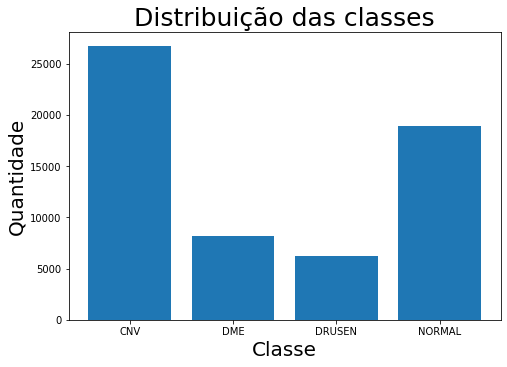

In [ ]:
total_cnv_samples = len(glob.glob(trainDataDir + 'CNV/*'))
total_dme_samples = len(glob.glob(trainDataDir + 'DME/*'))
total_drusen_samples = len(glob.glob(trainDataDir + 'DRUSEN/*'))
total_normal_samples = len(glob.glob(trainDataDir + 'NORMAL/*'))

sample_distribution = [total_cnv_samples, total_dme_samples, total_drusen_samples, total_normal_samples]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes, sample_distribution)
plt.xlabel("Classe", fontsize=20)
plt.ylabel("Quantidade", fontsize=20)
#fig.set_size_inches( 25, 8)
plt.title("Distribuição das classes", fontsize=25) 
plt.show();

## Pré-Processamento - Tratamento dos dados para uso na rede neural

### Data Augmentation

##### Aumenta a quantidade de dados, adicionando cópias ligeiramente modificadas de dados já existentes ou dados sintéticos recém-criados a partir de dados existentes

In [ ]:
train_batchSize = 64
val_batchSize = 1

In [ ]:
trainDataGen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=9,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest'
                                  )

trainGenerator = trainDataGen.flow_from_directory(trainDataDir,
                                                  target_size=(299, 299), ## O tamanho padrão da imagem de entrada para a rede neural Xception é 299 x 299
                                                  batch_size=train_batchSize,
                                                  class_mode='categorical',
                                                  shuffle = True
                                                  )

validationDataGen = ImageDataGenerator(rescale=1./255)

validationGenerator = validationDataGen.flow_from_directory(validationDataDir,
                                                            target_size=(299, 299), ## O tamanho padrão da imagem de entrada para a rede neural Xception é 299 x 299
                                                            batch_size=val_batchSize,
                                                            class_mode='categorical',
                                                            )


testDataGen = ImageDataGenerator(rescale=1./255)

testGenerator = testDataGen.flow_from_directory(testDataDir,
                                                      target_size=(299, 299), ## O tamanho padrão da imagem de entrada para a rede neural Xception é 299 x 299
                                                      batch_size=val_batchSize,
                                                      class_mode=None,
                                                      )

Found 60108 images belonging to 4 classes.
Found 15026 images belonging to 4 classes.
Found 8350 images belonging to 4 classes.


### Balanceamento do dataset

##### Não aumenta as amostras, mas atribui pesos a cada classe para evitar qualquer viés por meio de dados não balanceados (class_weights), os pesos são passados para o model.fit

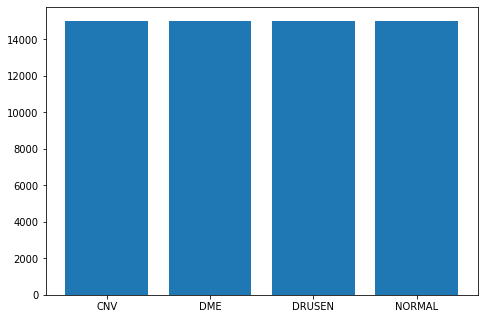

In [ ]:
weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(trainGenerator.classes), y = trainGenerator.classes)
class_weights = {i: weights[i] for i in range(len(weights))}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes, sample_distribution*weights) # Distribuição das classes com o ajuste dos pesos (class_weights)
plt.show()

## Rede Neural Xception pré-treinada utilizando a base de dados "imageNet"

https://keras.io/api/applications/xception/

https://arxiv.org/abs/1610.02357

83697664/83683744 [==============================] - 2s 0us/step


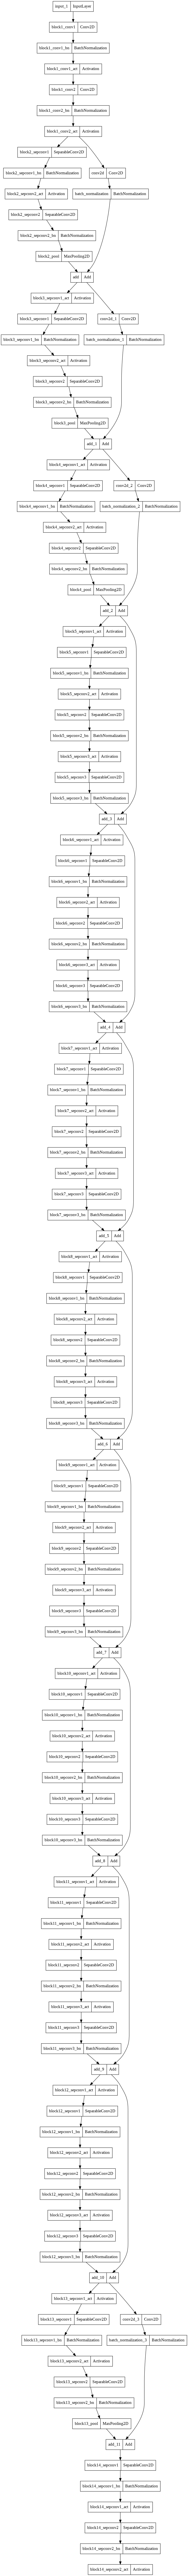

In [ ]:
# Carregar a rede Xception certificando-se de que as camadas principais Full Connected (FC) sejam deixadas de fora

baseModel = Xception(include_top=False, weights='imagenet', input_shape=(299,299,3))

# Congela todas as camadas do modelo para que * não * sejam atualizadas durante o primeiro processo de treinamento
for layer in baseModel.layers:
    layer.trainable = False

plot_model(baseModel)

In [ ]:
init_lr = 0.045
epochs = 40
num_classes = len(classes)
batchSize = 64

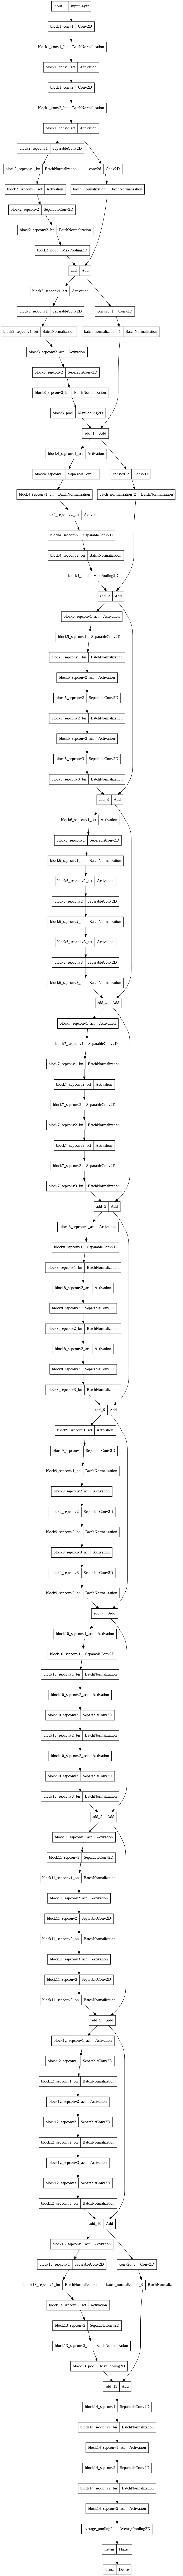

In [ ]:
# Construir as camadas Full Connected (FC) "top" do modelo, que substituirão a base da Xception

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)

# Construir o modelo CNN
model = Model(inputs=baseModel.input, outputs=headModel)

# Compilar o modelo
opt = SGD(lr=init_lr, decay=init_lr / epochs, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["categorical_accuracy"])

plot_model(model)

### Callbacks

In [ ]:
es = EarlyStopping(patience=10, monitor="val_loss", mode='min', restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
mc = ModelCheckpoint(filepath = saveResultDir + 'kfold5_model.h5', monitor='categorical_accuracy', save_best_only=True, mode='max')

### Treinamento

In [ ]:
# Treinamento
tf.keras.backend.clear_session()

stepsTraining = trainGenerator.samples // train_batchSize
stepsValidation = validationGenerator.samples // val_batchSize

history = model.fit(trainGenerator,
                    steps_per_epoch = stepsTraining,
                    epochs=epochs,
                    validation_data = validationGenerator,
                    validation_steps = stepsValidation,
                    class_weight=class_weights,
                    callbacks=[es,rlr,mc]
                    )

Epoch 1/40
939/939 [==============================] - 6597s 7s/step - loss: 2.2889 - categorical_accuracy: 0.6976 - val_loss: 1.2195 - val_categorical_accuracy: 0.8148 - lr: 0.0450
Epoch 2/40
939/939 [==============================] - 6515s 7s/step - loss: 1.2686 - categorical_accuracy: 0.7601 - val_loss: 0.5924 - val_categorical_accuracy: 0.8622 - lr: 0.0450
Epoch 3/40
939/939 [==============================] - 6675s 7s/step - loss: 0.9299 - categorical_accuracy: 0.7818 - val_loss: 0.8016 - val_categorical_accuracy: 0.7938 - lr: 0.0450
Epoch 4/40
939/939 [==============================] - 6851s 7s/step - loss: 0.7830 - categorical_accuracy: 0.7937 - val_loss: 0.5086 - val_categorical_accuracy: 0.8545 - lr: 0.0450
Epoch 5/40
939/939 [==============================] - 6616s 7s/step - loss: 0.7213 - categorical_accuracy: 0.7992 - val_loss: 0.4784 - val_categorical_accuracy: 0.8563 - lr: 0.0450
Epoch 6/40
939/939 [==============================] - 6609s 7s/step - loss: 0.6502 - categorica

## Avaliação do Modelo

### Visualização do histórico de treinamento do Modelo

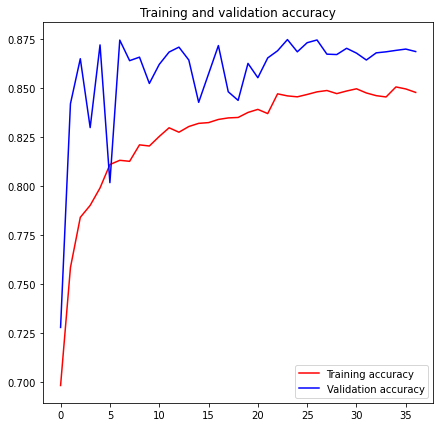

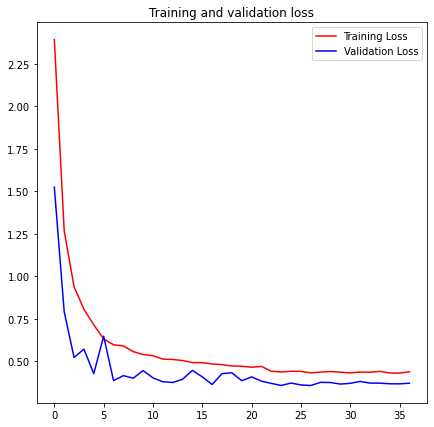

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
num_epochs = range(len(acc))

plt.figure(figsize=(7,7))
plt.plot(num_epochs, acc, 'r', label='Training accuracy')
plt.plot(num_epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(7,7))
plt.plot(num_epochs, loss, 'r', label='Training Loss')
plt.plot(num_epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show();

### Avaliação do modelo utilizando a base de teste

In [ ]:
test_images_path = glob.glob(testDataDir + '*/*.jpeg')
x_test = []
y_test = []
for i in range(len(test_images_path)):
    img = cv2.imread(test_images_path[i])
    img = cv2.resize(img, (299,299))
    img = np.array(img/255.0)
    x_test.append(img)
    if 'CNV' in test_images_path[i]:
        y_test.append(0)
    elif 'DME' in test_images_path[i]:
        y_test.append(1)
    elif 'DRUSEN' in test_images_path[i]:
        y_test.append(2)
    elif 'NORMAL' in test_images_path[i]:
        y_test.append(3)
y_test = np.array(y_test)
x_test = np.array(x_test)
print(x_test.shape, y_test.shape)

(8350, 299, 299, 3) (8350,)


In [ ]:
model.load_weights(saveResultDir + 'kfold5_model.h5') # carrega os pesos da melhor rede
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)

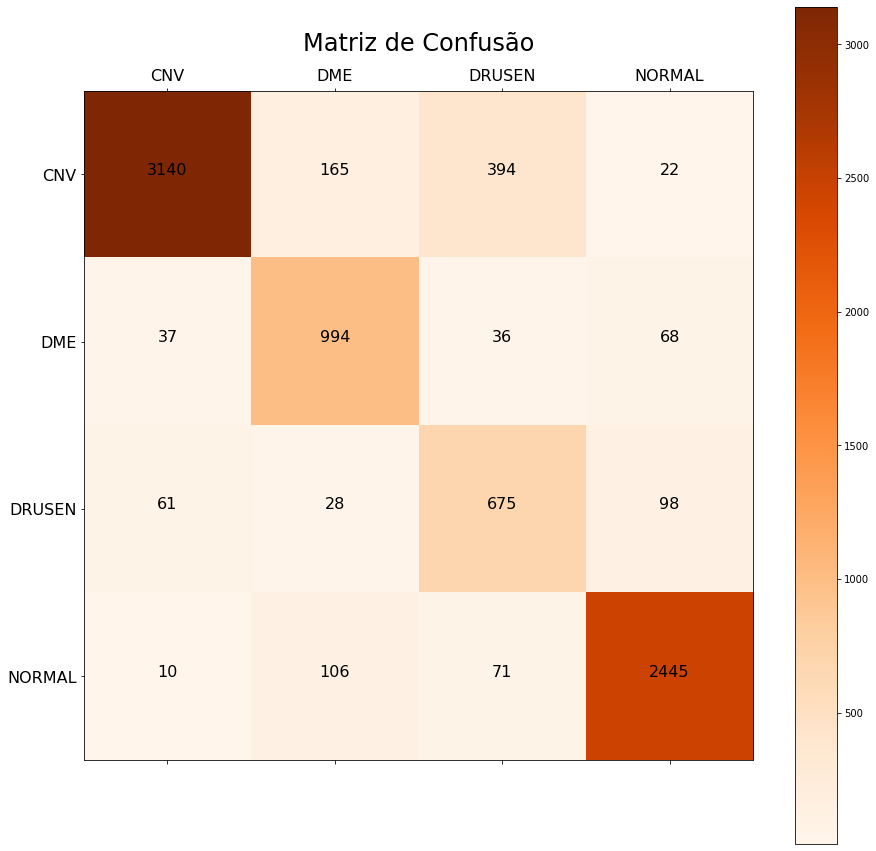

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
df = pd.DataFrame(cm)
plt.figure(figsize=(15, 15))
plt.matshow(df, cmap=plt.get_cmap('Oranges'), fignum=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,fontsize=16)
plt.yticks(tick_marks, classes, fontsize=16)
#thresh = 0.6

for i in range(num_classes):
    for j in range(num_classes):
        plt.text(i, j, df[i][j],
                 horizontalalignment='center', fontsize = 16)

plt.tight_layout()
plt.title('Matriz de Confusão', fontsize=24)
plt.ylabel(df.index.name, fontsize=18)
plt.xlabel(df.columns.name,fontsize=18)
plt.show()

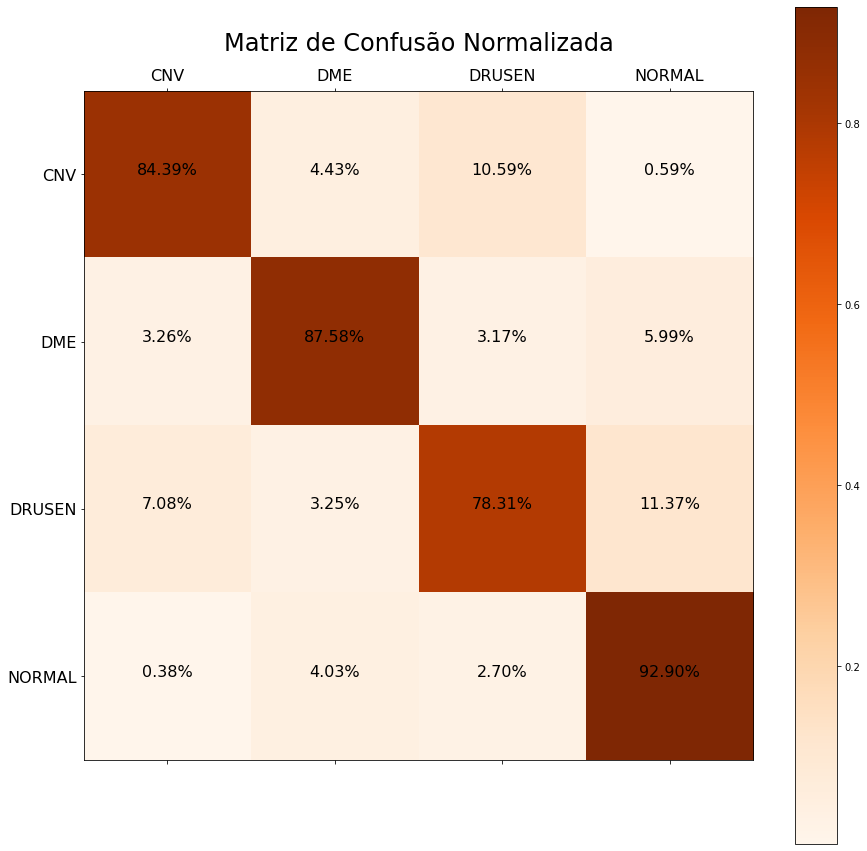

In [ ]:
cm_norm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test), normalize='true')
df_norm = pd.DataFrame(cm_norm)
plt.figure(figsize=(15, 15))
plt.matshow(df_norm, cmap=plt.get_cmap('Oranges'), fignum=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,fontsize=16)
plt.yticks(tick_marks, classes, fontsize=16)
#thresh = 0.6

for i in range(num_classes):
    for j in range(num_classes):
        plt.text(i, j, "{:0.2f}%".format(df_norm[i][j] * 100),
                 horizontalalignment='center', fontsize = 16)

plt.tight_layout()
plt.title('Matriz de Confusão Normalizada', fontsize=24)
plt.ylabel(df_norm.index.name, fontsize=18)
plt.xlabel(df_norm.columns.name,fontsize=18)
plt.show()

In [ ]:
report = (classification_report(y_test, y_pred, target_names = classes, output_dict=True))
df_class_report = pd.DataFrame(report).transpose()
print(classification_report(y_test, y_pred, target_names = classes))

              precision    recall  f1-score   support

         CNV       0.97      0.84      0.90      3721
         DME       0.77      0.88      0.82      1135
      DRUSEN       0.57      0.78      0.66       862
      NORMAL       0.93      0.93      0.93      2632

    accuracy                           0.87      8350
   macro avg       0.81      0.86      0.83      8350
weighted avg       0.89      0.87      0.87      8350



In [ ]:
df_class_report.to_csv(saveResultDir + '/kfold5_classification_report.csv',encoding='utf-8')

In [ ]:
drive.flush_and_unmount()